# Gluon interface example for `fred_md`

This notebook contains an example of training the TACTiS model on the `fred_md` dataset, using the same hyperparameters as in the paper, but with a reduced training time.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Configuration
import os
import sys
REPO_NAME = "tactis-2"
def get_repo_basepath():
    cd = os.path.abspath(os.curdir)
    return cd[:cd.index(REPO_NAME) + len(REPO_NAME)]
REPO_BASE_PATH = get_repo_basepath()
sys.path.append(REPO_BASE_PATH)

In [3]:
import torch
from tactis.gluon.estimator import TACTiSEstimator
from tactis.gluon.trainer import TACTISTrainer
from tactis.gluon.dataset import generate_hp_search_datasets, generate_prebacktesting_datasets, generate_backtesting_datasets
from tactis.gluon.metrics import compute_validation_metrics
from tactis.gluon.plots import plot_four_forecasts
from gluonts.evaluation.backtest import make_evaluation_predictions

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## Loading the dataset

This loads the dataset as it was used during the hyperparameter search experiments.

In [4]:
history_factor = 1

metadata, train_data, valid_data = generate_hp_search_datasets("fred_md", history_factor)

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/s

## Creating the GluonTS Estimator object

The following hyperparameters (together with the history factor of 1) are those used in our benchmark for `fred_md`, although with a reduced training time since we took a limit of 3 days for our benchmark.

In [5]:
estimator = TACTiSEstimator(
    model_parameters = {
        "flow_series_embedding_dim": 5,
        "copula_series_embedding_dim": 5,
        "flow_input_encoder_layers": 2,
        "copula_input_encoder_layers": 2,
        "input_encoding_normalization": True,
        "data_normalization": "standardization",
        "loss_normalization": "series",
        "bagging_size": 20,
        "positional_encoding":{
            "dropout": 0.0,
        },
        "flow_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_temporal_encoder":{
            "attention_layers": 2,
            "attention_heads": 1,
            "attention_dim": 16,
            "attention_feedforward_dim": 16,
            "dropout": 0.0,
        },
        "copula_decoder":{
            "min_u": 0.05,
            "max_u": 0.95,
            "attentional_copula": {
                "attention_heads": 3,
                "attention_layers": 1,
                "attention_dim": 8,
                "mlp_layers": 2,
                "mlp_dim": 48,
                "resolution": 20,
                "activation_function": "relu"
            },
            "dsf_marginal": {
                "mlp_layers": 2,
                "mlp_dim": 48,
                "flow_layers": 2,
                "flow_hid_dim": 8,
            },
        },
    },
    num_series = train_data.list_data[0]["target"].shape[0],
    history_length = history_factor * metadata.prediction_length,
    prediction_length = metadata.prediction_length,
    freq = metadata.freq,
    trainer = TACTISTrainer(
        epochs_phase_1 = 20,
        epochs_phase_2 = 20,
        batch_size = 256,
        num_batches_per_epoch = 512,
        learning_rate = 1e-3,
        weight_decay = 1e-4,
        maximum_learning_rate = 1e-3,
        clip_gradient = 1e3,
        device = torch.device("cuda:3"),
    ),
    cdf_normalization = False,
    num_parallel_samples = 100,
)

Checkpoints will not be saved


## The training

In [6]:
model = estimator.train(train_data, valid_data)

Start epoch: 0
Total epochs: 100
Epochs: 100
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 100
Training...
Total number of training batches: 50


/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


Epoch: 0 Average training loss: 508476.125
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 0 Average validation loss: 36.00815200805664
Epochs since best epoch: 0
Epoch: 1 / 100
Training...
Total number of training batches: 50
Epoch: 1 Average training loss: 4225.76708984375
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 1 Average validation loss: 34.15032958984375
Epochs since best epoch: 0
Epoch: 2 / 100
Training...
Total number of training batches: 50
Epoch: 2 Average training loss: 32.02016830444336
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 2 Average validation loss: 33.3193244934082
Epochs since best epoch: 0
Epoch: 3 / 100
Training...
Total number of training batches: 50
Epoch: 3 Average training loss: 31.882707595825195
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 3 Average validation loss: 33.60908889770508
Epochs since best epoch: 1
Epoch: 4 / 1

Epoch: 20 Average training loss: -0.03470823913812637
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 20 Average validation loss: 0.1426188349723816
Epochs since best epoch: 0
Epoch: 21 / 100
Training...
Total number of training batches: 50
Epoch: 21 Average training loss: -0.07057146728038788
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 21 Average validation loss: 0.09273365885019302
Epochs since best epoch: 1
Epoch: 22 / 100
Training...
Total number of training batches: 50
Epoch: 22 Average training loss: -0.12354947626590729
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 22 Average validation loss: 0.12305877357721329
Epochs since best epoch: 2
Epoch: 23 / 100
Training...
Total number of training batches: 50
Epoch: 23 Average training loss: -0.7354276776313782
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 23 Average validation loss: -1.2598416805267334
Ep

## Metrics

Measuring the metrics on the validation dataset. Note that we use `split=True` due to the validation dataset not already being split into multiple timestamps.

We reduce the batch size since we generate many samples in parallel (see the `num_parallel_samples` parameter of the Estimator object), without using bagging. The extra memory usage is somewhat compensated by not having to keep gradient information, but not completely.

In [7]:
# Enable copula in the model_parameters since the copula is now trained
# This needs to be done again here since a 
# TACTiSPredictionNetwork is created for inference from the `model_parameters`
estimator.model_parameters["skip_copula"] = False

# Create predictor
transformation = estimator.create_transformation()
device = estimator.trainer.device
predictor = estimator.create_predictor(
    transformation=transformation,
    trained_network=model,
    device=device,
    experiment_mode="forecasting",
    history_length=history_factor * metadata.prediction_length,
)

In [13]:
predictor.batch_size = 16
metrics, ts_wise_metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=valid_data,
    window_length=estimator.history_length + estimator.prediction_length,
    prediction_length=estimator.prediction_length,
    num_samples=100,
    split=True,
)

Using batch size: 16


/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


In [14]:
metrics

{'CRPS': 0.07551998529224618,
 'ND': 0.09234120752112916,
 'NRMSE': 0.9122062947101212,
 'MSE': 785346484.1322645,
 'CRPS-Sum': 0.04010959886287652,
 'ND-Sum': 0.05244852456732187,
 'NRMSE-Sum': 0.07304397609018366,
 'MSE-Sum': 56461355656.03654,
 'num_nan': 0,
 'num_inf': 0}

## Plotting the forecasts

Plot the forecast for the last timestamp of the validation dataset.

In [15]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=valid_data, predictor=predictor, num_samples=100
)
forecasts = list(forecast_it)
targets = list(ts_it)

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


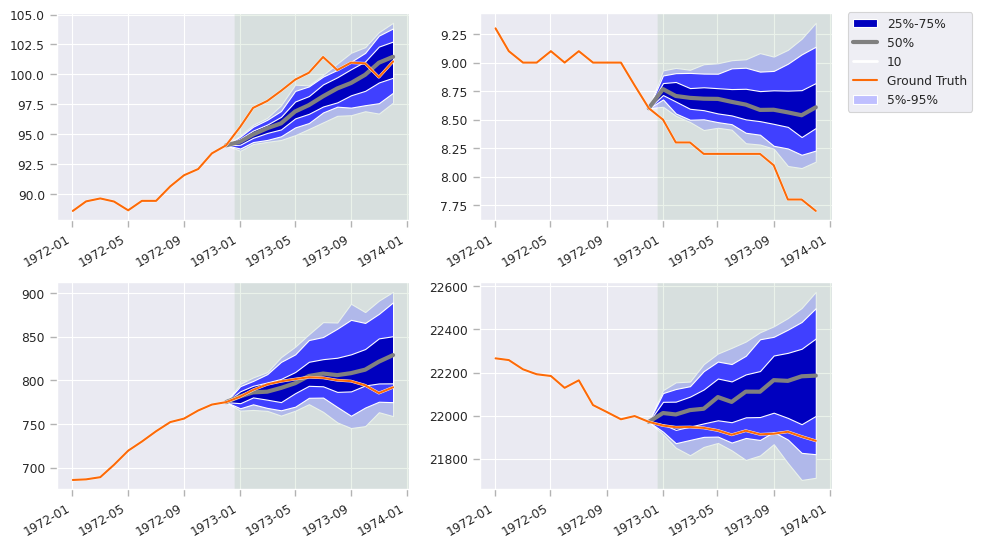

In [16]:
plot_four_forecasts(
    forecasts=forecasts,
    targets=targets,
    selection=[(0, 10), (0, 20), (0, 30), (0, 40)],
    tick_freq="4 months end",
    history_length=estimator.history_length,
)

## Loading and training with the backtesting dataset

Similar to how the dataset was loaded for the hyperparameter search, but we need to select a backtesting id.

In [17]:
backtest_id = 3
metadata, backtest_train_data, backtest_valid_data = generate_prebacktesting_datasets("fred_md", backtest_id, history_factor)
_, _, backtest_test_data = generate_backtesting_datasets("fred_md", backtest_id, history_factor)

/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:106: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  timestamp + (len(data[FieldName.TARGET]) - 1) * timestamp.freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:108: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  self.frequency = timestamp.freq
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:217: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/multivariate_grouper.py:166: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  freq=data[FieldName.START].freq,
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/

In [18]:
model = estimator.train(backtest_train_data, backtest_valid_data)

Start epoch: 0
Total epochs: 100
Epochs: 100
Flow loss weight: 1.0
Copula loss weight: 0.0
Epoch: 0 / 100
Training...
Total number of training batches: 50


/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/transform/split.py:36: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return _shift_timestamp_helper(ts, ts.freq, offset)


Epoch: 0 Average training loss: 201867.765625
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 0 Average validation loss: 32.171241760253906
Epochs since best epoch: 0
Epoch: 1 / 100
Training...
Total number of training batches: 50


/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:324: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  timestamp = pd.Timestamp(timestamp_input, freq=freq)
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:327: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  if isinstance(timestamp.freq, Tick):
/home/toolkit/.conda/envs/tactis/lib/python3.10/site-packages/gluonts/dataset/common.py:338: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version.
  return timestamp.freq.rollforward(timestamp)


Epoch: 1 Average training loss: 629.7977294921875
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 1 Average validation loss: 33.66084289550781
Epochs since best epoch: 1
Epoch: 2 / 100
Training...
Total number of training batches: 50
Epoch: 2 Average training loss: 31.996809005737305
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 2 Average validation loss: 34.06639862060547
Epochs since best epoch: 2
Epoch: 3 / 100
Training...
Total number of training batches: 50
Epoch: 3 Average training loss: 32.3214225769043
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 3 Average validation loss: 33.238346099853516
Epochs since best epoch: 3
Epoch: 4 / 100
Training...
Total number of training batches: 50
Epoch: 4 Average training loss: 32.382503509521484
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 4 Average validation loss: 31.514896392822266
Epochs since best epoch: 0
E

Epoch: 20 Average training loss: -0.026592226698994637
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 20 Average validation loss: 0.11974914371967316
Epochs since best epoch: 1
Epoch: 21 / 100
Training...
Total number of training batches: 50
Epoch: 21 Average training loss: -0.04416908323764801
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 21 Average validation loss: 0.08920150250196457
Epochs since best epoch: 2
Epoch: 22 / 100
Training...
Total number of training batches: 50
Epoch: 22 Average training loss: -0.0660184919834137
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 22 Average validation loss: 0.397930771112442
Epochs since best epoch: 3
Epoch: 23 / 100
Training...
Total number of training batches: 50
Epoch: 23 Average training loss: -0.3186762034893036
Validation...
Creating a validation dataloader with a batch size of 256
Epoch: 23 Average validation loss: -0.3621186316013336
Epo

## Metrics for the testing dataset

Unlike the validation dataset, the testing dataset is already split, so no need to ask the metrics method to split it.

In [19]:
# Enable copula in the model_parameters since the copula is now trained
# This needs to be done again here since a 
# TACTiSPredictionNetwork is created for inference from the `model_parameters`
estimator.model_parameters["skip_copula"] = False

# Create predictor
transformation = estimator.create_transformation()
device = estimator.trainer.device
predictor = estimator.create_predictor(
    transformation=transformation,
    trained_network=model,
    device=device,
    experiment_mode="forecasting",
    history_length=history_factor * metadata.prediction_length,
)

In [21]:
predictor.batch_size = 16
metrics, ts_wise_metrics = compute_validation_metrics(
    predictor=predictor,
    dataset=valid_data,
    window_length=estimator.history_length + estimator.prediction_length,
    prediction_length=estimator.prediction_length,
    num_samples=100,
    split=False,
)

Using batch size: 16


In [22]:
metrics

{'CRPS': 0.03356029622010833,
 'ND': 0.04802738186486513,
 'NRMSE': 0.4550307909709574,
 'MSE': 337673424.72304285,
 'CRPS-Sum': 0.026492253707129553,
 'ND-Sum': 0.038158543434956047,
 'NRMSE-Sum': 0.046895516156747176,
 'MSE-Sum': 41062492842.666664,
 'num_nan': 0,
 'num_inf': 0}